In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
import re
import nltk
import tqdm
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# OLID dataset
def load_dataset_1():
    df = pd.read_csv(r'..\\OLID_Tain.txt', delimiter='\t', skiprows=1, names=['id', 'tweet', 'subtask_a', 'label2', 'label3']) # Nebos line

    # Clean and preprocess the data
    def clean_tweet(tweet):
        tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)  # Remove @ mentions
        tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)  # Remove URLs
        tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)  # Only keep text characters
        tweet = re.sub(r" +", ' ', tweet)  # Remove multiple spaces
        return tweet.strip()

    df['tweet'] = df['tweet'].apply(clean_tweet)
    df = df[df['subtask_a'] != 'NULL']  # Ensure we only use labeled data
    label_map = {'OFF': 1, 'NOT': 0}
    df['label'] = df['subtask_a'].map(label_map)

    # Split data into training, validation, and test sets
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['tweet'].values, df['label'].values, test_size=0.2, random_state=42)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42)

    # Tokenization and encoding
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

    # Convert to torch tensors
    train_seq = torch.tensor(train_encodings['input_ids'])
    train_mask = torch.tensor(train_encodings['attention_mask'])
    train_y = torch.tensor(train_labels)

    val_seq = torch.tensor(val_encodings['input_ids'])
    val_mask = torch.tensor(val_encodings['attention_mask'])
    val_y = torch.tensor(val_labels)

    test_seq = torch.tensor(test_encodings['input_ids'])
    test_mask = torch.tensor(test_encodings['attention_mask'])
    test_y = torch.tensor(test_labels)

    # DataLoader setup
    batch_size = 32
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_seq, test_mask, test_y)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    print(len(train_data), len(val_data), len(test_data))

    return train_dataloader, val_dataloader, test_dataloader

In [3]:
# HASOC dataset
def clean_tweet(tweet):
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)  # Remove @ mentions
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)  # Remove URLs
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)  # Only keep text characters
    tweet = re.sub(r" +", ' ', tweet)  # Remove multiple spaces
    return tweet.strip()

def load_df(file_path):
    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, names=['id', 'tweet', 'subtask_a', 'label2', 'label3']) # Nebos line
    df['tweet'] = df['tweet'].apply(clean_tweet)
    df = df[df['subtask_a'] != 'NULL'] 
    label_map = {'HOF': 1, 'NOT': 0}
    df['label'] = df['subtask_a'].map(label_map)
    return df

def load_dataset_2():
    file1 = r'..\\BiLSTM-Multiple-Datasets\\additional_datasets\\HASOCData\\english_dataset.tsv'
    file2 = r'..\\BiLSTM-Multiple-Datasets\\additional-datasets\\HASOCData\\ehasoc2019_en_test-2919.tsv'

    df = load_df(file1)

    # Split data into training, validation, and test sets
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['tweet'].values, df['label'].values, test_size=0.2, random_state=42)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42)

    # Tokenization and encoding
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

    # Convert to torch tensors
    train_seq = torch.tensor(train_encodings['input_ids'])
    train_mask = torch.tensor(train_encodings['attention_mask'])
    train_y = torch.tensor(train_labels)

    val_seq = torch.tensor(val_encodings['input_ids'])
    val_mask = torch.tensor(val_encodings['attention_mask'])
    val_y = torch.tensor(val_labels)

    test_seq = torch.tensor(test_encodings['input_ids'])
    test_mask = torch.tensor(test_encodings['attention_mask'])
    test_y = torch.tensor(test_labels)

    # DataLoader setup
    batch_size = 32
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_seq, test_mask, test_y)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    print(len(train_data), len(val_data), len(test_data))

    return train_dataloader, val_dataloader, test_dataloader

In [4]:
train_dataloader, val_dataloader, test_dataloader = load_dataset_2()

4681 585 586


In [8]:
# Model configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Optimizer and learning rate scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:


# Training loop
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Example')
    plt.legend(loc="lower right")
    plt.show()


# Updated evaluate function
def evaluate(dataloader, in_loop=False):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        loss = outputs[0]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_true, y_pred) 
    if not in_loop: 
        plot_roc_curve(fpr, tpr, roc_auc)
        cfx = confusion_matrix(y_true, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cfx, display_labels = [0, 1])
        cm_display.plot()
        plt.show()


    avg_loss = total_eval_loss / len(dataloader)
    return total_eval_accuracy / len(dataloader.dataset), avg_loss, f1



def test_model(model, test_loader):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        loss = outputs[0]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)
    f1 = f1_score(y_true, y_pred)


    # Calculate metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
# Validation function
train_losses = []
val_losses = []

# Training loop with loss tracking
for epoch in range(3):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    val_accuracy, avg_val_loss, val_f1 = evaluate(val_dataloader, in_loop=True)
    val_losses.append(avg_val_loss)
    print(
        f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.3f} | Validation Loss: {avg_val_loss:.3f} | Validation F1: {val_f1:.3f}")

Epoch 1 | Train Loss: 0.637 | Validation Loss: 0.590 | Validation F1: 0.473
Epoch 2 | Train Loss: 0.554 | Validation Loss: 0.599 | Validation F1: 0.545
Epoch 3 | Train Loss: 0.469 | Validation Loss: 0.641 | Validation F1: 0.517


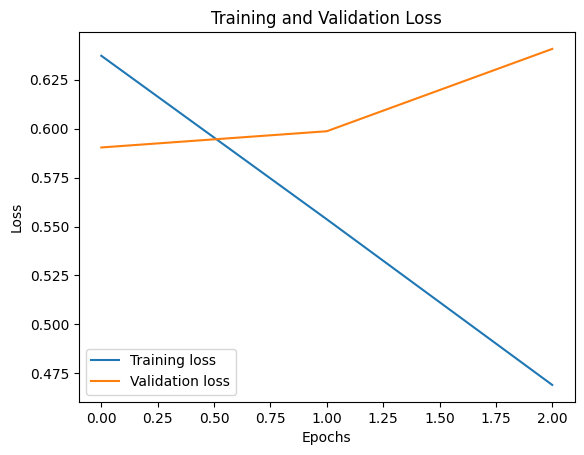

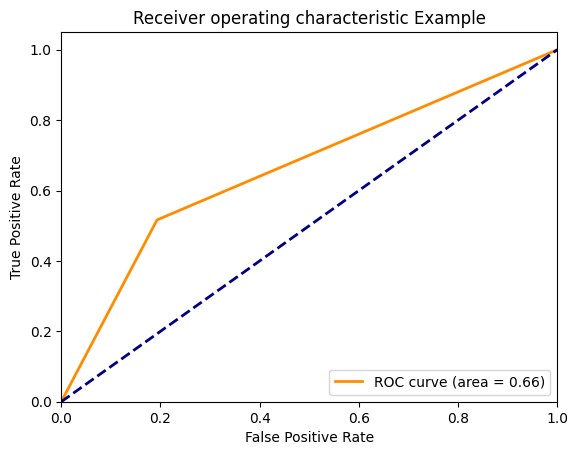

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.77       373
           1       0.60      0.52      0.56       213

    accuracy                           0.70       586
   macro avg       0.67      0.66      0.67       586
weighted avg       0.69      0.70      0.70       586

Confusion Matrix
[[301  72]
 [103 110]]


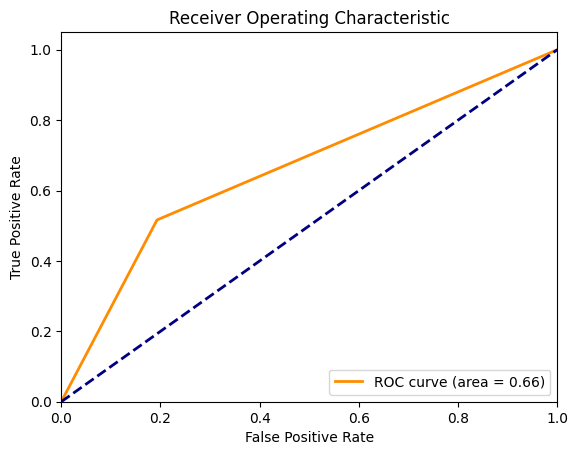

Test Accuracy: None


In [10]:
# Plot training and validation losses
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_accuracy = test_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy}")